# Exemplary Training: Q-Learning, SARSA and DQN



This notebook aims to demonstrate the training process of an agent in practise. For simplicity only the stowage planning problem for a small RORO deck is shown with the loading list outlined in the corresponding thesis (for algorithms default values have been defined which may be found in the annex of the thesis)

On the other hand the notebook `Example.ipynb` shows  how an already trained model could be used in practise.


***
## Imports

Firstly various modules are imported (including agent classes, environment classes, a plotting unit and a logger)

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
module_path = str(os.getcwd())+'\\out\\'

from Plotter import Plotter
from valuation.evaluator import *
from loggingUnit import LoggingBase
from env.roroDeck import RoRoDeck
from agent import SARSA, TDQLearning, dqn
from agent.TDQLearning import TDQLearning
from agent.SARSA import SARSA
from agent.dqn import DQNAgent
import logging

Using TensorFlow backend.


***
## Register logger and set training duration

The first step is to register the logging unit. This will also set the output path where the trained models will be saved. Furthermore it has to be decided on how many iterations the agent should be trained. If this is not set the agent will fall back on default values.

In [2]:
# Register Output path and Logger
loggingBase = LoggingBase()
module_path = loggingBase.module_path

number_of_episodes = 50_000

***
## Initalise the environment

Secondly the environment is initialised. It can be decided the size of the environment and if it should behave stochasticly. If `stochastic` is set to true than the agent will behave with probability $p$ (`env.p`) determinisitic in a sense that the cargo type chosen by the agent is actually loaded. Subsequently, a random cargo type is loaded with probability $1-p$.

**Note:** In the thesis the environment is said to be deterministic. Since deviations are not assumed to happen regularly.

The `vehicle_data` variable corresponds to the loading list which may be changed by the user. After every change the environment needs to be reset.

The `reset()`-method will return the representation of the intial state.

In [3]:
env = RoRoDeck(False, stochastic=False)
print(env.vehicle_data)
env.reset()

[[ 0  1  2  3  4]
 [ 1  2  1  2  2]
 [ 1  1  0  0  1]
 [ 2  3  2  3  2]
 [ 5  5 -1 -1  2]
 [ 0  0  0  0  1]]


array([4, 3, 2, 1, 1, 2, 3, 4, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 1, 1, 1,
       1, 0, 3], dtype=int16)

***
## Train the agent

Train the agent with the environment.
The user may choose between different algorithms:
- TDQ-Learning
- SARSA
- Deep Q-Learning (DQN)

The training is started by calling `agent.train()`. After the last training episode the `train()`-method will show a grid representation of the final stowage plan.

**Important Note:** The run time of this method might depend on how much memory is already used for Jupyter-Notebooks and on the browser settings. The `main`-method of `training.py` is demonstrating the usage equivalently and might run faster.

In [4]:
# Choose algorithm from list
algorithms = ['SARSA','TDQ','DQN']
algorithm = algorithms[0]


# If DQN is used the number of episodes should not exceed roughly 14_000 (default value)
# to solve the problem in reasonable time if GPU cannot be used for training

if algorithm is 'DQN':
    #number_of_episodes = 14_000
    assert number_of_episodes <= 14_000


print('Train agent with '+algorithm+'\n')

if algorithm == 'SARSA':
    agent = SARSA(env, module_path, number_of_episodes)
elif algorithm == 'TDQ':
    agent = TDQLearning(env, module_path, number_of_episodes)
else:
    agent = DQNAgent(env=env, module_path=module_path, gamma=0.999, number_of_episodes=number_of_episodes, epsilon=1.0,
                     alpha=0.0005,
                     mem_size=1_000_000, pretraining_duration=10_000,
                     batch_size=32, epsilon_min=0.01, epsilon_dec=0.99999, layers=[250, 250, 250, 250, 250])
    
# Call train-method
model, total_rewards, vehicle_loaded, eps_history, state_expansion = agent.train()
# Save model to output path
agent.save_model(module_path)

Train agent with SARSA

Start Training Process
episode  500 	score -119.00 	avg. score -137.61
episode  1000 	score -14.00 	avg. score -133.85
episode  1500 	score -226.00 	avg. score -147.25
episode  2000 	score -195.00 	avg. score -134.02
episode  2500 	score -197.00 	avg. score -140.80
episode  3000 	score -206.00 	avg. score -135.49
episode  3500 	score -132.00 	avg. score -133.75
episode  4000 	score -245.00 	avg. score -134.27
episode  4500 	score -142.00 	avg. score -136.46
episode  5000 	score -120.00 	avg. score -122.07
episode  5500 	score -106.00 	avg. score -132.63
episode  6000 	score -114.00 	avg. score -123.92
episode  6500 	score -302.00 	avg. score -125.98
episode  7000 	score -64.00 	avg. score -123.26
episode  7500 	score -80.00 	avg. score -121.79
episode  8000 	score -115.00 	avg. score -119.76
episode  8500 	score -158.00 	avg. score -112.19
episode  9000 	score -49.00 	avg. score -117.04
episode  9500 	score -144.00 	avg. score -112.59
episode  10000 	score 22.00

***
## Plot training performance

This will plot:
1. Reward over time
2. The size of the Q-table if this was a tabular method (State Expansion).
3. The steps to finish (also how may vehicles are loaded to the deck)
4. The EPSILON development over time for EPSILON-greedy exploration.

**Note:** The smothing window will smooth the ouput plots to make trends more visible. It will take the average of the last $n$ iterations where $n$ corresponds to the number defined by the variable `smoothing_window`. This is highly recommended.

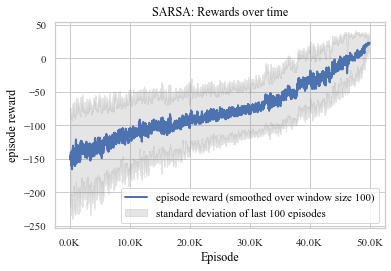

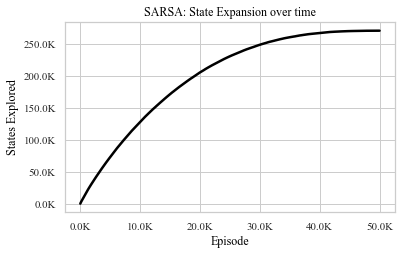

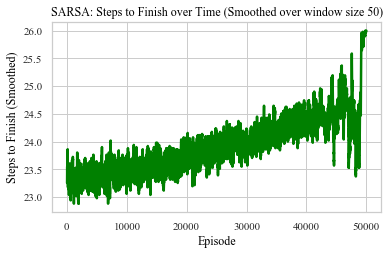

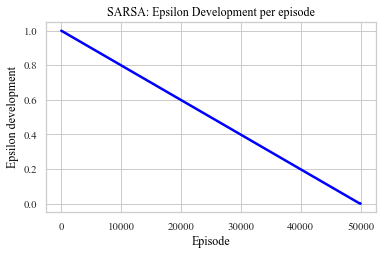

In [5]:
plotter = Plotter(module_path, number_of_episodes, algorithm=algorithm, smoothing_window=100)
plotter.plot(total_rewards, state_expansion, vehicle_loaded, eps_history)

***
## Evaluation

Evaluate the final stowage plan after execution always the best action.

An optimal stowage plan would result in:

> Mandatory Cargo Loaded: 1.0

This stowage plan will load 100% of the mandatory cargo and ...

> Number of Shifts: 0.0

... causes zero shifts.

> Space Utilisation: 1.0

Moreover the space is used to 100%.


The final stowage plan created by the agent evaluates as follows:

In [6]:
evaluator = Evaluator(env.vehicle_data, env.grid)
evaluation = evaluator.evaluate(env.get_stowage_plan())
print(evaluation)

Mandatory Cargo Loaded: 1.0
Number of Shifts: 0.0
Space Utilisation: 0.9833333333333333
